In [1]:
# check API key
import os

api_key = os.environ.get("OPENAI_API_KEY")
if api_key:
    print("API key is set")
else:
    print("API key not found in environment variables")

API key is set


In [2]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes, image_file_to_odes_str
client = OpenAIClient()

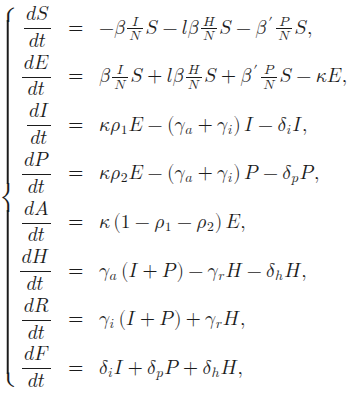

In [3]:
# Extract ODEs from image
from IPython.display import Image
image_path = 'images/BIOMD0000000958.png'
Image(image_path)

In [4]:
ode_str = image_file_to_odes_str('images/BIOMD0000000958.png', client=client)
print(ode_str)
# Note that the LLM sometimes misses to define one of the parameters. When this happens, a human-in-the-loop can quickly edit the output

INFO: [2025-09-02 18:05:04] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, P, A, H, R, F = sympy.symbols("S E I P A H R F", cls=sympy.Function)

# Define the parameters
beta, l, beta_prime, kappa, rho_1, rho_2, gamma_a, gamma_i, delta_I, delta_P = sympy.symbols("beta l beta_prime kappa rho_1 rho_2 gamma_a gamma_i delta_I delta_P")

odes = [
    sympy.Eq(S(t).diff(t), -beta * I(t) * S(t) / N - l * beta * H(t) / N - beta_prime * P(t) * S(t)),
    sympy.Eq(E(t).diff(t), beta * I(t) * S(t) / N + l * beta * H(t) / N + beta_prime * P(t) * S(t) - kappa * E(t)),
    sympy.Eq(I(t).diff(t), kappa * rho_1 * E(t) - (gamma_a + gamma_i) * I(t) - delta_I * I(t)),
    sympy.Eq(P(t).diff(t), kappa * rho_2 * E(t) - (gamma_a + gamma_i) * P(t) - delta_P * P(t)),
    sympy.Eq(A(t).diff(t), kappa * (1 - rho_2) * E(t)),
    sympy.Eq(H(t).diff(t), gamma_a * (I(t) + P(t)) - gamma_r * H(t) - delta_H * H(t)),
    sympy.Eq(R(t).diff(t), gamma_i * (I(t) + P(t)) * H(t)),
    sympy.E

In [5]:
# Now get a template model from the extracted ODE str and send the ODE system in for attempting to ground each compartment
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes

tm = execute_template_model_from_sympy_odes(ode_str=ode_str, attempt_grounding=True, client=client)

INFO: [2025-09-02 18:05:11] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Running multi-agent validation...


INFO: [2025-09-02 18:05:25] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM response: {
  "has_errors": true,
  "errors": {
    "execution_errors": [
      "Missing definitions for delta_H and gamma_r.",
      "Missing import for Function and Derivative."
    ],
    "parameter_errors": [],
    "time_dependency_errors": [],
    "concept_errors": []
  },
  "auto_fixes_applied": [
    "Added import statements for Function and Derivative.",
    "Defined delta_H and gamma_r as parameters."
  ],
  "corrected_code": "from sympy import symbols, Function, Eq, Derivative\n\n# Define time v...
Iteration 1: Found errors: {'execution_errors': ['Missing definitions for delta_H and gamma_r.', 'Missing import for Function and Derivative.'], 'parameter_errors': [], 'time_dependency_errors': [], 'concept_errors': []}
DEBUG: Response keys: dict_keys(['has_errors', 'errors', 'auto_fixes_applied', 'corrected_code', 'corrected_concepts', 'manual_review_needed'])
DEBUG: corrected_code exists, first 100 chars: from sympy import symbols, Function, Eq, Derivative

# Define time

INFO: [2025-09-02 18:05:37] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM response: {
  "has_errors": true,
  "errors": {
    "execution_errors": [],
    "parameter_errors": [],
    "time_dependency_errors": [],
    "concept_errors": [
      "Compartment 'P' should be treated as a Function due to its use in derivatives."
    ]
  },
  "auto_fixes_applied": [
    "Defined P as a Function and updated usage in equations."
  ],
  "corrected_code": "from sympy import symbols, Function, Eq, Derivative\n\nt = symbols('t')\nN = symbols('N', positive=True)\n\nS, E, I, P, A, H, R, F = [Fu...
Iteration 2: Found errors: {'execution_errors': [], 'parameter_errors': [], 'time_dependency_errors': [], 'concept_errors': ["Compartment 'P' should be treated as a Function due to its use in derivatives."]}
DEBUG: Response keys: dict_keys(['has_errors', 'errors', 'auto_fixes_applied', 'corrected_code', 'corrected_concepts', 'manual_review_needed'])
DEBUG: corrected_code exists, first 100 chars: from sympy import symbols, Function, Eq, Derivative

t = symbols('t')
N = symbo

INFO: [2025-09-02 18:05:53] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw LLM response: {
  "has_errors": true,
  "errors": {
    "execution_errors": [
      "Function definitions for S, E, I, P, A, H, R, and F must use Function('X') and be updated to X(t) in the equations."
    ],
    "parameter_errors": [],
    "time_dependency_errors": [
      "All compartments (S, E, I, P, A, H, R, F) must be defined as functions."
    ],
    "concept_errors": [
      "Concept entries for P and A should be distinct; they currently share the same identifiers. This could lead to confusion regardi...
Iteration 3: Found errors: {'execution_errors': ["Function definitions for S, E, I, P, A, H, R, and F must use Function('X') and be updated to X(t) in the equations."], 'parameter_errors': [], 'time_dependency_errors': ['All compartments (S, E, I, P, A, H, R, F) must be defined as functions.'], 'concept_errors': ['Concept entries for P and A should be distinct; they currently share the same identifiers. This could lead to confusion regarding their contexts.']}
DEBUG: Respon

In [6]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
P	{'ido': '0000511'}	{'stage': 'predromal', 'species': 'ncbitaxon:9606'}
I	{'ido': '0000511'}	{'stage': 'infectious', 'species': 'ncbitaxon:9606'}
H	{'ido': '0000511'}	{'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}
E	{'apollosv': '00000154'}	{'species': 'ncbitaxon:9606'}
R	{'ido': '0000592'}	{'species': 'ncbitaxon:9606'}
S	{'ido': '0000514'}	{'species': 'ncbitaxon:9606'}
F	{'ido': '0000592'}	{'outcome': 'fatalities', 'species': 'ncbitaxon:9606'}
A	{'ido': '0000511'}	{'disease_severity': 'ncit:C3833', 'species': 'ncbitaxon:9606'}


In [7]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
om.get_interpretable_kinetics()

Matrix([
[Derivative(P, t), =,                               E*kappa*rho_2 - P*delta_P - P*(gamma_a + gamma_i)],
[Derivative(I, t), =,                               E*kappa*rho_1 - I*delta_I - I*(gamma_a + gamma_i)],
[Derivative(H, t), =,                                        -H*delta_H - H*gamma_r + gamma_a*(I + P)],
[Derivative(E, t), =, -E*kappa*rho_2 - E*kappa*(1 - rho_2) + H*beta*l/N + I*S*beta/N + P*S*beta_prime],
[Derivative(R, t), =,                                                               H*gamma_i*(I + P)],
[Derivative(S, t), =,                                       -H*beta*l/N - I*S*beta/N - P*S*beta_prime],
[Derivative(F, t), =,                                               H*delta_H + I*delta_I + P*delta_P],
[Derivative(A, t), =,                                                             E*kappa*(1 - rho_2)]])

#### Saving the results here: *mira/notebooks/equation extraction development/extraction error check/string mismatch check/extracted_eqs_all versions_EXCEL.xlsx*

In [8]:
import pandas as pd
from pathlib import Path

In [9]:
def save_ode_results(ode_str, input_filename):
    """
    Save ODE extraction results to Excel file.
    
    Parameters:
    -----------
    ode_str : str
        The extracted ODEs from MIRA
    input_filename : str
        The input file name (e.g., 'model_name.png')
    """

    excel_path = './equation extraction development/extraction error check/string mismatch check/extracted_eqs_all versions_EXCEL.xlsx'
    model_name = Path(input_filename).stem

    try:
        df = pd.read_excel(excel_path, engine='openpyxl')
    except FileNotFoundError:
        df = pd.DataFrame(columns=['model', 'version002'])

    if 'model' in df.columns:
        model_exists = df['model'] == model_name

        if model_exists.any():
            df.loc[model_exists, 'version002'] = ode_str
        else:
            new_row = pd.DataFrame({
                'model': [model_name],
                'version002': [ode_str]
            })
            df = pd.concat([df, new_row], ignore_index=True)
    else:
        df['model'] = model_name
        df['version002'] = ode_str

    df.to_excel(excel_path, index=False, engine='openpyxl')
    print(f"Saved equations for model '{model_name}'")